In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import lightgbm as lgb
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_profiling

In [53]:
# ## plotly 
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)

In [78]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')

In [79]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

## FE

In [89]:
train_df.tail(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190_scaled,var_191_scaled,var_192_scaled,var_193_scaled,var_194_scaled,var_195_scaled,var_196_scaled,var_197_scaled,var_198_scaled,var_199_scaled
199990,train_199990,1,14.1475,1.8568,11.0066,3.6779,12.1944,-16.5936,5.3217,14.8508,...,0.254920,0.514976,0.508994,0.618629,0.630793,0.755528,0.324021,0.524629,0.335436,0.482285
199991,train_199991,0,9.9909,2.5523,11.9653,6.3958,13.5497,-9.5293,6.0864,14.1789,...,0.818763,0.537945,0.420606,0.353033,0.447577,0.638067,0.281723,0.421751,0.310196,0.415144
199992,train_199992,0,12.2825,2.6918,15.4684,6.4262,10.9863,9.9659,4.5030,9.9232,...,0.583065,0.781400,0.464437,0.563540,0.627983,0.553853,0.680361,0.693357,0.517740,0.351424
199993,train_199993,0,13.2152,-5.8006,9.7260,6.5910,12.4612,-7.1652,6.0666,12.9887,...,0.582602,0.697705,0.501528,0.219132,0.702225,0.623766,0.653446,0.492819,0.371581,0.609666
199994,train_199994,0,12.3925,-5.8821,11.2323,3.9237,10.4509,10.7262,7.0503,18.6968,...,0.506703,0.613099,0.655191,0.588066,0.311725,0.425195,0.326329,0.516946,0.461307,0.405416
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,0.647349,0.871591,0.671363,0.405629,0.497971,0.391285,0.515445,0.420297,0.479270,0.267936
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,0.612793,0.511440,0.411564,0.435536,0.715781,0.757159,0.381750,0.126641,0.440261,0.516203
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,0.586422,0.548555,0.603120,0.538395,0.779591,0.415438,0.488528,0.450531,0.336670,0.577948
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,0.545475,0.689959,0.574380,0.752026,0.621122,0.575471,0.655486,0.669705,0.421144,0.319944
199999,train_199999,0,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,...,0.729888,0.356508,0.363577,0.386978,0.351002,0.314196,0.379586,0.363069,0.254643,0.513143


In [86]:
var_list = [f for f in train_df.columns if 'var' in f]
# rank_var_list = [f+'_rank' for f in train_df.columns if 'var' in f]
# sort_var_list = ['sort_var_' + str(i) for i in range(len(var_list))]
#cut_var_list = [f+'_cut' for f in var_list]
scaled_var_list = [f+'_scaled' for f in var_list]

In [88]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pt = PowerTransformer(standardize=True)
minmax_scaler = MinMaxScaler()

train_df[scaled_var_list] = pd.DataFrame(pt.fit_transform(train_df[var_list]))
train_df[scaled_var_list] = pd.DataFrame(minmax_scaler.fit_transform(train_df[scaled_var_list]))
test_df[scaled_var_list] = pd.DataFrame(pt.fit_transform(test_df[var_list]))
test_df[scaled_var_list] = pd.DataFrame(minmax_scaler.fit_transform(test_df[scaled_var_list]))




# train_df[cut_var_list] = train_df[var_list].apply(lambda x: pd.cut(x, 50, labels=False))
# test_df[cut_var_list] = test_df[var_list].apply(lambda x: pd.cut(x, 50, labels=False))

# train_df[std_var_list] = train_df[var_list].sub(train_df[var_list].mean(1), axis=0).div(train_df[var_list].std(1), axis=0)
# test_df[std_var_list] = test_df[var_list].sub(test_df[var_list].mean(1), axis=0).div(test_df[var_list].std(1), axis=0)

# train_df['mean'] = np.mean(train_df[var_list],axis=1)
# train_df['std'] = np.std(train_df[var_list],axis=1)
# train_df['min'] = np.min(train_df[var_list],axis=1)
# train_df['max'] = np.max(train_df[var_list],axis=1)
# train_df['sum'] = np.sum(train_df[var_list],axis=1)
# train_df['median'] = np.median(train_df[var_list],axis=1)

# train_df[mean_var_list] = (train_df[var_list]-np.median(train_df[var_list],axis=0))/((np.max(train_df[var_list],axis=0)-np.median(train_df[var_list],axis=0)))
# test_df[mean_var_list] = (test_df[var_list]-np.median(test_df[var_list],axis=0))/((np.max(test_df[var_list],axis=0)-np.median(test_df[var_list],axis=0)))


# train_df[rank_var_list] = train_df[var_list].rank(method='average',pct=True)
# test_df[rank_var_list] = test_df[var_list].rank(method='average',pct=True)

# train_df[rank_var_list] = train_df[rank_var_list].multiply(train_df[var_list].values)
# test_df[rank_var_list]  = test_df[rank_var_list].multiply(test_df[var_list].values)



# #simple stats on rank cols 
# train_df['mean'] = np.mean(train_df[rank_var_list],axis=1)
# train_df['std'] = np.std(train_df[rank_var_list],axis=1)
# train_df['min'] = np.min(train_df[rank_var_list],axis=1)
# train_df['max'] = np.max(train_df[rank_var_list],axis=1)
# train_df['sum'] = np.sum(train_df[rank_var_list],axis=1)
# train_df['median'] = np.median(train_df[rank_var_list],axis=1)

# train_df['rank_of_rank_mean'] = train_df['mean'].rank(method='average',pct=True)
# train_df['rank_of_rank_std'] = train_df['std'].rank(method='average',pct=True)
# train_df['rank_of_rank_min'] = train_df['min'].rank(method='average',pct=True)
# train_df['rank_of_rank_max'] = train_df['max'].rank(method='average',pct=True)
# train_df['rank_of_rank_sum'] = train_df['sum'].rank(method='average',pct=True)
# train_df['rank_of_rank_median'] = train_df['median'].rank(method='average',pct=True)


# #simple stats on rank cols 
# test_df['mean'] = np.mean(test_df[rank_var_list],axis=1)
# test_df['std'] = np.std(test_df[rank_var_list],axis=1)
# test_df['min'] = np.min(test_df[rank_var_list],axis=1)
# test_df['max'] = np.max(test_df[rank_var_list],axis=1)
# test_df['sum'] = np.sum(test_df[rank_var_list],axis=1)
# test_df['median'] = np.median(test_df[rank_var_list],axis=1)

# test_df['rank_of_rank_mean'] = test_df['mean'].rank(method='average',pct=True)
# test_df['rank_of_rank_std'] = test_df['std'].rank(method='average',pct=True)
# test_df['rank_of_rank_min'] = test_df['min'].rank(method='average',pct=True)
# test_df['rank_of_rank_max'] = test_df['max'].rank(method='average',pct=True)
# test_df['rank_of_rank_sum'] = test_df['sum'].rank(method='average',pct=True)
# test_df['rank_of_rank_median'] = test_df['median'].rank(method='average',pct=True)

# train_df[sort_var_list] = train_df[var_list].rank(method='average',pct=True)
# test_df[rank_var_list] = test_df[var_list].rank(method='average',pct=True)


# value_train = train_df[var_list].values
# value_train.sort(axis=1)
# value_train = pd.DataFrame(value_train, train_df.index, sort_var_list)
# train_df[sort_var_list] = value_train

# value_test = test_df[var_list].values
# value_test.sort(axis=1)
# value_test = pd.DataFrame(value_test, test_df.index, sort_var_list)
# test_df[sort_var_list] = value_test

# nlargest = 25
# new_col_names = ['top{}'.format(i) for i in range(1, nlargest+1)]
# order = np.argsort(-train_df[var_list].values, axis=1)[:, :nlargest]
# top_n_train = pd.DataFrame(
#                      #test_df[var_list].columns[order],
#                       order,
#                       columns=new_col_names,
#                       index=train_df.index)

# train_df[new_col_names] = top_n_train

# order = np.argsort(-test_df[var_list].values, axis=1)[:, :nlargest]
# top_n_train = pd.DataFrame(
#                      #test_df[var_list].columns[order],
#                       order,
#                       columns=new_col_names,
#                       index=train_df.index)

# test_df[new_col_names] = top_n_train


# nsmallest = 25
# new_col_names = ['bottom{}'.format(i) for i in range(1, nsmallest+1)]
# order = np.argsort(train_df[var_list].values, axis=1)[:, :nsmallest]
# top_n_train = pd.DataFrame(
#                      #test_df[var_list].columns[order],
#                       order,
#                       columns=new_col_names,
#                       index=train_df.index)

# train_df[new_col_names] = top_n_train
# order = np.argsort(test_df[var_list].values, axis=1)[:, :nsmallest]
# top_n_train = pd.DataFrame(
#                      #test_df[var_list].columns[order],
#                       order,
#                       columns=new_col_names,
#                       index=test_df.index)

# test_df[new_col_names] = top_n_train

In [90]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190_scaled,var_191_scaled,var_192_scaled,var_193_scaled,var_194_scaled,var_195_scaled,var_196_scaled,var_197_scaled,var_198_scaled,var_199_scaled
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,0.376617,0.812822,0.195642,0.457627,0.242645,0.798866,0.623980,0.740009,0.397635,0.397501
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,0.737734,0.687791,0.419471,0.729660,0.344946,0.599614,0.429348,0.599540,0.585664,0.235671
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,0.419261,0.778162,0.509869,0.448186,0.202278,0.765527,0.236680,0.142290,0.626543,0.207164
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,0.709220,0.698144,0.482167,0.497202,0.323703,0.867072,0.610556,0.493968,0.278549,0.459311
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,0.561872,0.702226,0.449643,0.490061,0.559531,0.519737,0.303701,0.178640,0.321925,0.391225


## Model

In [91]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

n_folds = 5
random_seed = 26
model = 'pt_and_minmax_scale'


model_name = "{0}_{1}_folds".format(model, n_folds)
print("Model: {}".format(model_name))

Model: pt_and_minmax_scale_5_folds


In [92]:
#feats = train_df.iloc[:,2:].columns.tolist();feats

#exclusion = ['ID_code', 'target']+ rank_var_list
exclusion = ['ID_code', 'target'] + var_list

feats = [c for c in train_df.columns if c not in exclusion]

#cat_feats = [c for c in feats if c not in var_list]

In [93]:
feats

['var_0_scaled',
 'var_1_scaled',
 'var_2_scaled',
 'var_3_scaled',
 'var_4_scaled',
 'var_5_scaled',
 'var_6_scaled',
 'var_7_scaled',
 'var_8_scaled',
 'var_9_scaled',
 'var_10_scaled',
 'var_11_scaled',
 'var_12_scaled',
 'var_13_scaled',
 'var_14_scaled',
 'var_15_scaled',
 'var_16_scaled',
 'var_17_scaled',
 'var_18_scaled',
 'var_19_scaled',
 'var_20_scaled',
 'var_21_scaled',
 'var_22_scaled',
 'var_23_scaled',
 'var_24_scaled',
 'var_25_scaled',
 'var_26_scaled',
 'var_27_scaled',
 'var_28_scaled',
 'var_29_scaled',
 'var_30_scaled',
 'var_31_scaled',
 'var_32_scaled',
 'var_33_scaled',
 'var_34_scaled',
 'var_35_scaled',
 'var_36_scaled',
 'var_37_scaled',
 'var_38_scaled',
 'var_39_scaled',
 'var_40_scaled',
 'var_41_scaled',
 'var_42_scaled',
 'var_43_scaled',
 'var_44_scaled',
 'var_45_scaled',
 'var_46_scaled',
 'var_47_scaled',
 'var_48_scaled',
 'var_49_scaled',
 'var_50_scaled',
 'var_51_scaled',
 'var_52_scaled',
 'var_53_scaled',
 'var_54_scaled',
 'var_55_scaled',
 '

Current Fold: 1
AUC = 0.8911297297454253
getting feature importance
Current Fold: 2
AUC = 0.8900684039849113
getting feature importance
Current Fold: 3
AUC = 0.8954287691614192
getting feature importance
Current Fold: 4
AUC = 0.895215417152074
getting feature importance
Current Fold: 5
AUC = 0.893738642227629
getting feature importance
Overall AUC = 0.8929245958292267
Saving submission file


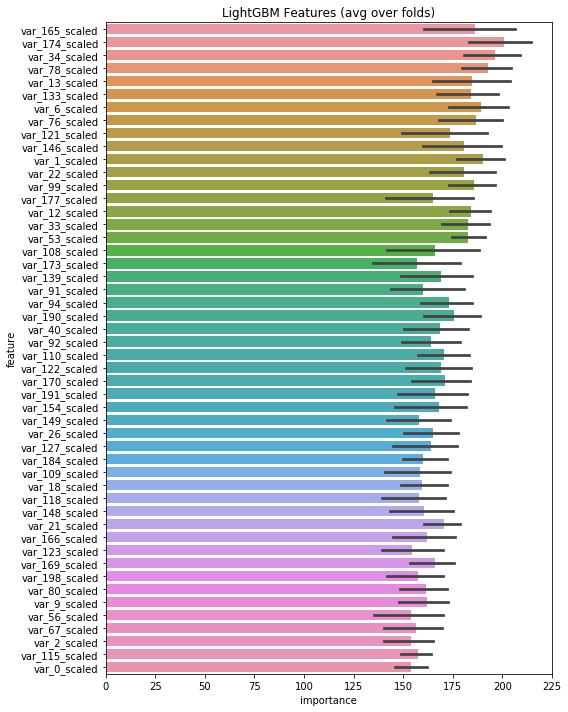

In [94]:
clfs = []
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))


X = train_df[feats]
y = train_df['target']
X_test = test_df[feats]
test_ids = test_df.ID_code.values


parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    #'scale_pos_weight': 400,
    #'device' : 'gpu' ,
    'boosting': 'gbdt',
    'num_leaves': 31, #31
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'learning_rate': 0.05, #0.05
    'verbose': 30
    #'min_data_in_leaf': 200
}

feature_importance_df = pd.DataFrame()
for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
    print("Current Fold: {}".format(fold_+1))
    trn_x, trn_y = X.iloc[trn_, :], y[trn_]
    val_x, val_y = X.iloc[val_, :], y[val_]


    trn_lgb = lgb.Dataset(trn_x, trn_y)
    val_lgb = lgb.Dataset(val_x, val_y)
    clf = lgb.train(parameters,
                     train_set=trn_lgb,
                     #valid_sets=[valid_data_lgb,holdout_data_lgb],
                     valid_sets=[trn_lgb, val_lgb],
                     num_boost_round=3000,
                     early_stopping_rounds=50,
                     verbose_eval=False)
    


    val_pred = clf.predict(val_x)
    test_fold_pred = clf.predict(X_test)

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
    print('getting feature importance')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
test_preds /= n_folds
roc_score = roc_auc_score(y, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))


print("Saving submission file")
sample = pd.read_csv('../data/sample_submission.csv')
sample.target = test_preds.astype(float)
sample.ID_code = test_ids
sample.to_csv('../submissions/{}_{}.csv'.format(model_name,str(roc_score)), index=False)

display_importances(feature_importance_df)


In [50]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [51]:


shutil.copyfile(os.path.basename(NOTEBOOK_FULL_PATH), 
                             '../models/{}_{}.ipynb'.format(model_name, str(roc_score)))


'../models/50_additional_cut_5_folds_0.8928046189086314.ipynb'